# Dataset Link : https://www.kaggle.com/datasets/paultimothymooney/kermany2018


# Data Upload

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install unrar
!unrar x "/content/drive/MyDrive/Retinal OCT/resized_oct.rar" "/content/resized_oct/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/resized_oct/resized_oct/train/NORMAL/NORMAL-8050269-7.jpeg      94%  OK 
Extracting  /content/resized_oct/resized_oct/train/NORMAL/NORMAL-8050269-8.jpeg      94%  OK 
Extracting  /content/resized_oct/resized_oct/train/NORMAL/NORMAL-8050636-1.jpeg      94%  OK 
Extracting  /content/resized_oct/resized_oct/train/NORMAL/NORMAL-8050636-2.jpeg      94%  OK 
Extracting  /content/resized_oct/resized_oct/train/NORMAL/NORMAL-8055145-1.jpeg      94%  OK 
Extracting  /content/resized_oct/resized_oct/train/NORMAL/NORMAL-8055145-2.jpeg      94%  OK 
Extracting  /content/resized_oct/resized_oct/train/NORMAL/NORMAL-8055145-3.jpeg      94%  OK 
Extracting  /content/resized_oct/resized_oct/train/NORMAL/NORMAL-8055590-1.jpeg      94%  OK 
Extracting  /content/resized_oct/resized_oct/train/NORMAL/NORMAL-8055590-2.jpeg      94%  OK 
Extracting  /content/r

#  Data generators

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/resized_oct/resized_oct/train'
test_dir = '/content/resized_oct/resized_oct/test'


train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.05
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=128,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

print(f"Train Generator Image Count: {train_generator.samples}")
print(f"Validation Generator Image Count: {val_generator.samples}")


Found 79312 images belonging to 4 classes.
Found 4172 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Train Generator Image Count: 79312
Validation Generator Image Count: 4172


# Weight Balancing

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
class_counts = [0] * len(class_indices)


for _, labels in train_generator:
    for label in np.argmax(labels, axis=1):
        class_counts[label] += 1
    if sum(class_counts) >= train_generator.samples:
        break

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_indices)),
    y=np.concatenate([np.argmax(train_generator[i][1], axis=1) for i in range(len(train_generator))])
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Names:", class_names)
print("Class Counts:", class_counts)
print("Class Weights:", class_weights_dict)

Class Names: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
Class Counts: [35345, 10781, 8186, 25000]
Class Weights: {0: 0.5609845805630217, 1: 1.8391614878026157, 2: 2.4221842169557783, 3: 0.79312}


# Transfer Learning ( ResNet50)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

input_layer = Input(shape=(128, 128, 1))

x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(input_layer)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet_base.trainable = False
x = resnet_base(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)


output_layer = Dense(4, activation='softmax')(x)


model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,854,756 (91.00 MB)

 Trainable params: 266,788 (1.02 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=6,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Retinal OCT/TL/tl_resnet.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,

)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.75,
    patience=2,
    min_lr=0.00001
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr,checkpoint, early_stopping]
)

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4783 - loss: 1.2596
Epoch 1: val_accuracy improved from -inf to 0.46596, saving model to /content/drive/MyDrive/Retinal OCT/TL/tl_resnet.weights.h5
620/620 ━━━━━━━━━━━━━━━━━━━━ 104s 139ms/step - accuracy: 0.4784 - loss: 1.2595 - val_accuracy: 0.4660 - val_loss: 2.5949 - learning_rate: 0.0010
Epoch 2/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5771 - loss: 1.0903
Epoch 2: val_accuracy did not improve from 0.46596
620/620 ━━━━━━━━━━━━━━━━━━━━ 75s 120ms/step - accuracy: 0.5771 - loss: 1.0903 - val_accuracy: 0.2457 - val_loss: 3.8024 - learning_rate: 0.0010
Epoch 3/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5946 - loss: 1.0569
Epoch 3: val_accuracy improved from 0.46596 to 0.54362, saving model to /content/drive/MyDrive/Retinal OCT/TL/tl_resnet.weights.h5
620/620 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.5946 - loss: 1.0569 - val_accuracy: 0.5436 - val_loss: 1.1212 - learning_rate: 0.0010
Epoc

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 608ms/step - accuracy: 0.6417 - loss: 0.7863
Test Loss: 0.891922116279602, Test Accuracy: 0.5826446413993835


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_predictions = model.predict(test_generator, verbose=1)

predicted_labels = np.argmax(test_predictions, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 787ms/step


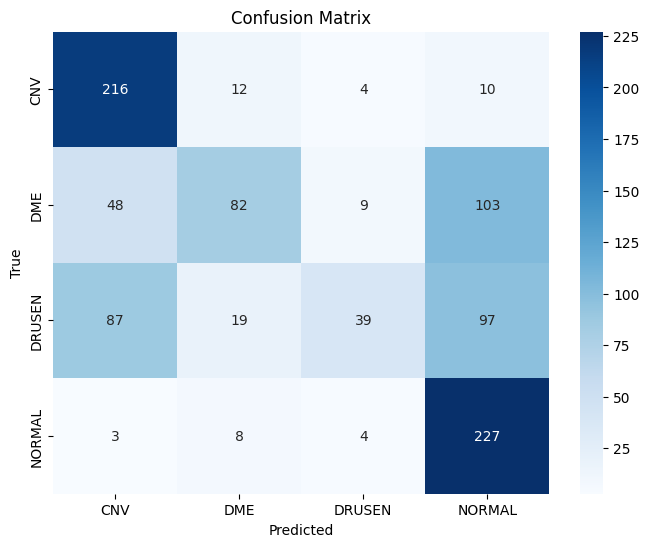

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Transfer Learning ( MobileNet)

In [ ]:
from tensorflow.keras.applications import ResNet50,MobileNet
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

input_layer = Input(shape=(128, 128, 1))
x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(input_layer)
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
mobilenet_base.trainable = False
x = mobilenet_base(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)


output_layer = Dense(4, activation='softmax')(x)

model_new = Model(inputs=input_layer, outputs=output_layer)

model_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_new.summary()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_128 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,364,836 (12.84 MB)

 Trainable params: 135,716 (530.14 KB)

 Non-trainable params: 3,229,120 (12.32 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=6,
    restore_best_weights=True

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Retinal OCT/TL/tl_mobilenet.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,

)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.75,
    patience=2,
    min_lr=0.00001
)
)

In [ ]:
history = model_new.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr,checkpoint, early_stopping]
)

Epoch 1/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6536 - loss: 0.9225
Epoch 1: val_accuracy improved from -inf to 0.79722, saving model to /content/drive/MyDrive/OCT/Transfer learning_oct/tl_xception.weights.h5
620/620 ━━━━━━━━━━━━━━━━━━━━ 123s 184ms/step - accuracy: 0.6537 - loss: 0.9223 - val_accuracy: 0.7972 - val_loss: 0.5447 - learning_rate: 0.0010
Epoch 2/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7540 - loss: 0.6907
Epoch 2: val_accuracy did not improve from 0.79722
620/620 ━━━━━━━━━━━━━━━━━━━━ 130s 170ms/step - accuracy: 0.7540 - loss: 0.6907 - val_accuracy: 0.7915 - val_loss: 0.5528 - learning_rate: 0.0010
Epoch 3/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7727 - loss: 0.6444
Epoch 3: val_accuracy did not improve from 0.79722
620/620 ━━━━━━━━━━━━━━━━━━━━ 142s 170ms/step - accuracy: 0.7727 - loss: 0.6444 - val_accuracy: 0.7884 - val_loss: 0.5558 - learning_rate: 0.0010
Epoch 4/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - ac

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_predictions = model_new.predict(test_generator, verbose=1)
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 565ms/step


In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

         CNV       0.73      0.99      0.84       242
         DME       0.95      0.87      0.91       242
      DRUSEN       0.96      0.69      0.80       242
      NORMAL       0.95      0.96      0.95       242

    accuracy                           0.88       968
   macro avg       0.90      0.88      0.88       968
weighted avg       0.90      0.88      0.88       968



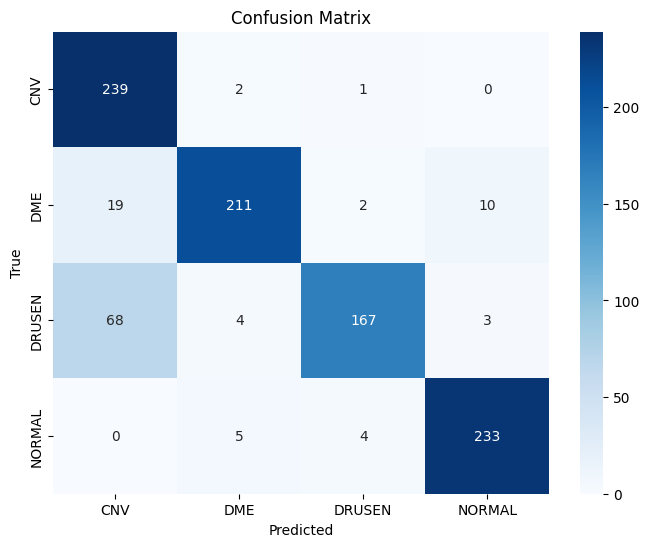

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

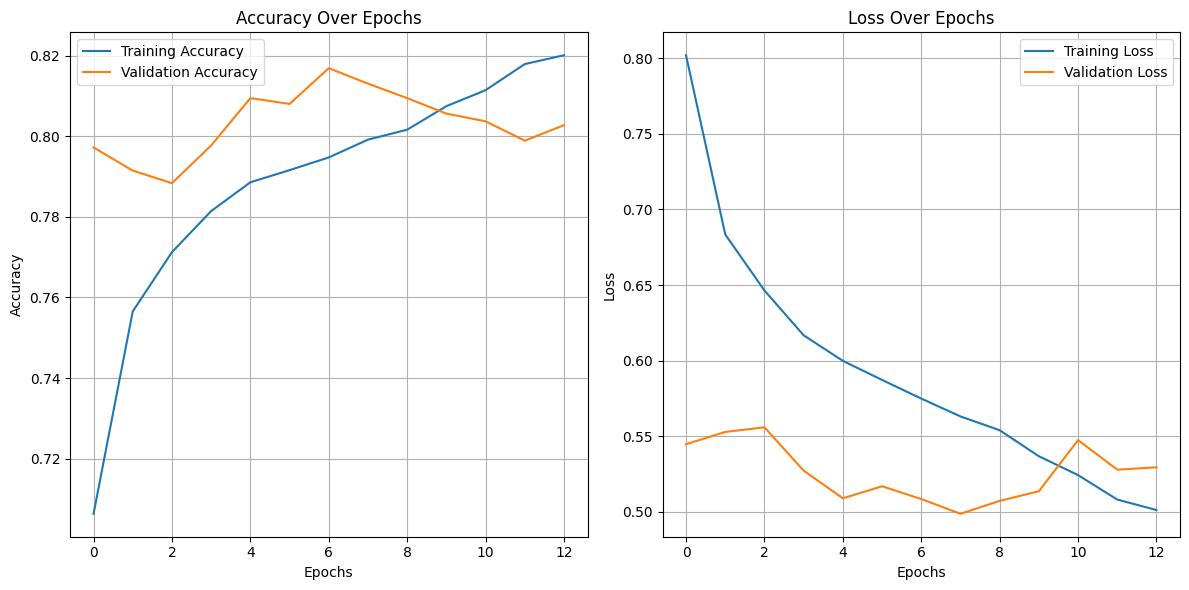

In [ ]:
import matplotlib.pyplot as plt
# Plotting Accuracy
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Transfer Learning ( VGG19)


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D,GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
import tensorflow as tf

input_layer = Input(shape=(128, 128, 1))
x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(input_layer)
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg19_base.trainable = False
x = vgg19_base(x)
x = GlobalMaxPooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)

output_layer = Dense(4, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,094,820 (76.66 MB)

 Trainable params: 70,180 (274.14 KB)

 Non-trainable params: 20,024,640 (76.39 MB)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 512)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,094,820 (76.66 MB)

 Trainable params: 70,180 (274.14 KB)

 Non-trainable params: 20,024,640 (76.39 MB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=6,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/OCT/Transfer learning_oct/tl_vgg.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,

)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.75,
    patience=2,
    min_lr=0.00001
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr,checkpoint, early_stopping]
)

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6127 - loss: 0.9943
Epoch 1: val_accuracy improved from -inf to 0.75144, saving model to /content/drive/MyDrive/OCT/Transfer learning_oct/tl_vgg.weights.h5
620/620 ━━━━━━━━━━━━━━━━━━━━ 187s 266ms/step - accuracy: 0.6128 - loss: 0.9940 - val_accuracy: 0.7514 - val_loss: 0.6263 - learning_rate: 0.0010
Epoch 2/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7407 - loss: 0.7199
Epoch 2: val_accuracy did not improve from 0.75144
620/620 ━━━━━━━━━━━━━━━━━━━━ 151s 216ms/step - accuracy: 0.7407 - loss: 0.7199 - val_accuracy: 0.7445 - val_loss: 0.6200 - learning_rate: 0.0010
Epoch 3/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7514 - loss: 0.6849
Epoch 3: val_accuracy did not improve from 0.75144
620/620 ━━━━━━━━━━━━━━━━━━━━ 133s 213ms/step - accuracy: 0.7514 - loss: 0.6849 - val_accuracy: 0.7323 - val_loss: 0.6485 - learning_rate: 0.0010
Epoch 4/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7644 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9130 - loss: 0.2483
Test Loss: 0.2802584171295166, Test Accuracy: 0.9059917330741882


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_predictions = model.predict(test_generator, verbose=1)
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step


In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

         CNV       0.83      0.95      0.89       242
         DME       0.96      0.86      0.91       242
      DRUSEN       0.93      0.83      0.88       242
      NORMAL       0.92      0.98      0.95       242

    accuracy                           0.91       968
   macro avg       0.91      0.91      0.91       968
weighted avg       0.91      0.91      0.91       968



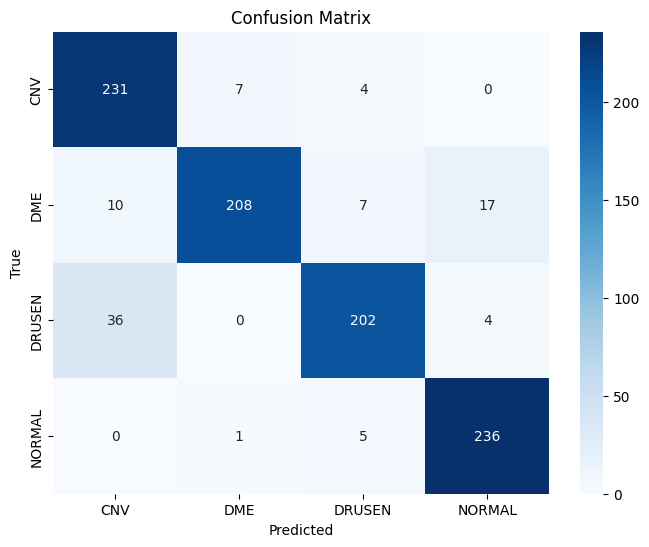

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

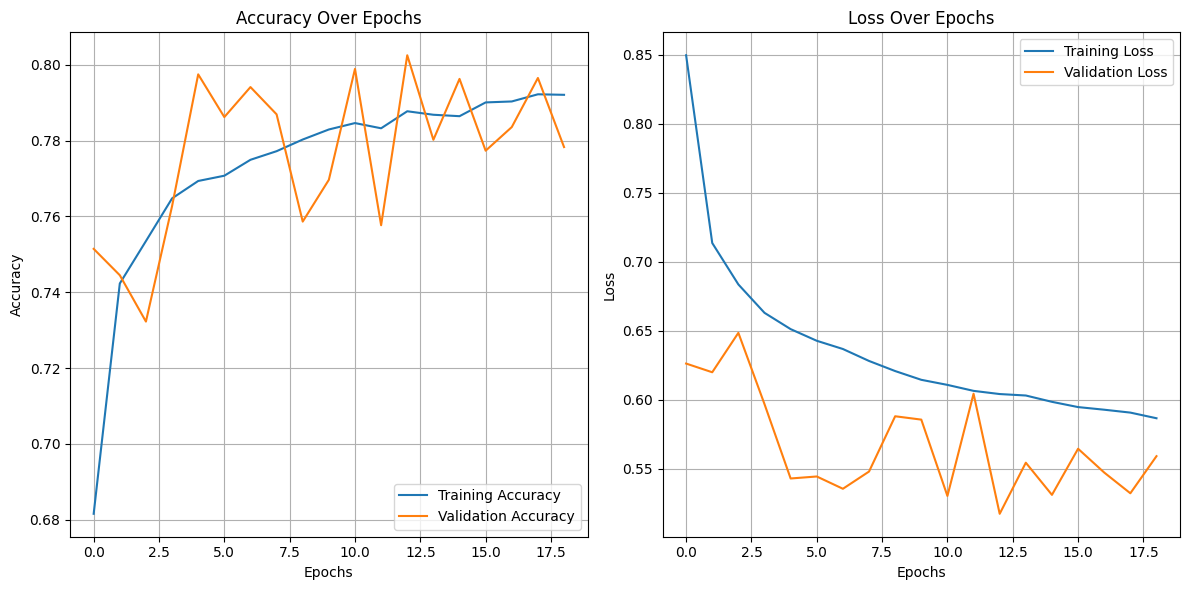

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Custom CNN

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(128, 128, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='valid')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)


output_layer = Dense(4, activation='softmax')(x)




In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 124, 124, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 31, 31, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,959,780 (7.48 MB)

 Trainable params: 1,959,396 (7.47 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=6,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Retinal OCT/Weighted_only/Weighted_base_model.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,

)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3819 - loss: 1.4923
Epoch 1: val_accuracy improved from -inf to 0.34204, saving model to /content/drive/MyDrive/Retinal OCT/Weighted_only/Weighted_base_model.weights.h5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 219s 166ms/step - accuracy: 0.3820 - loss: 1.4921 - val_accuracy: 0.3420 - val_loss: 1.7437
Epoch 2/35
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6482 - loss: 1.0102
Epoch 2: val_accuracy improved from 0.34204 to 0.34588, saving model to /content/drive/MyDrive/Retinal OCT/Weighted_only/Weighted_base_model.weights.h5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 247s 162ms/step - accuracy: 0.6482 - loss: 1.0102 - val_accuracy: 0.3459 - val_loss: 1.4273
Epoch 3/35
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7242 - loss: 0.8338
Epoch 3: val_accuracy improved from 0.34588 to 0.57430, saving model to /content/drive/MyDrive/Retinal OCT/Weighted_only/Weighted_base_model.weights.h5
1240/1240 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9628 - loss: 0.1645
Test Loss: 0.1569247841835022, Test Accuracy: 0.9648760557174683


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_predictions = model.predict(test_generator, verbose=1)

predicted_labels = np.argmax(test_predictions, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step


In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

         CNV       0.94      0.98      0.96       242
         DME       0.99      0.88      0.93       242
      DRUSEN       0.98      1.00      0.99       242
      NORMAL       0.96      1.00      0.98       242

    accuracy                           0.96       968
   macro avg       0.97      0.96      0.96       968
weighted avg       0.97      0.96      0.96       968



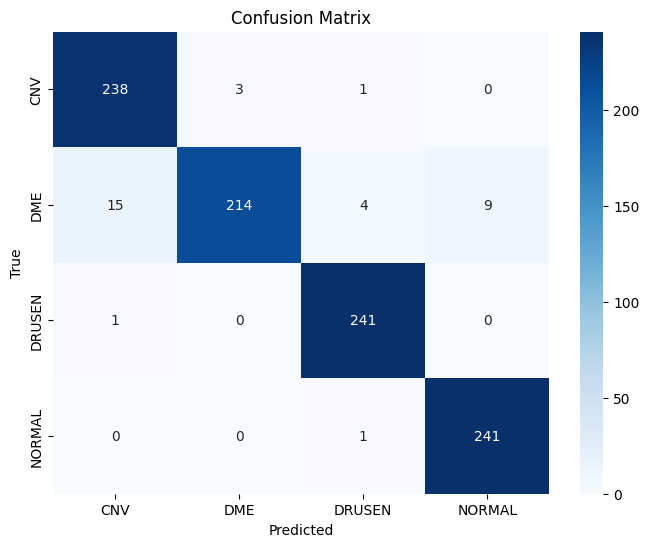

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

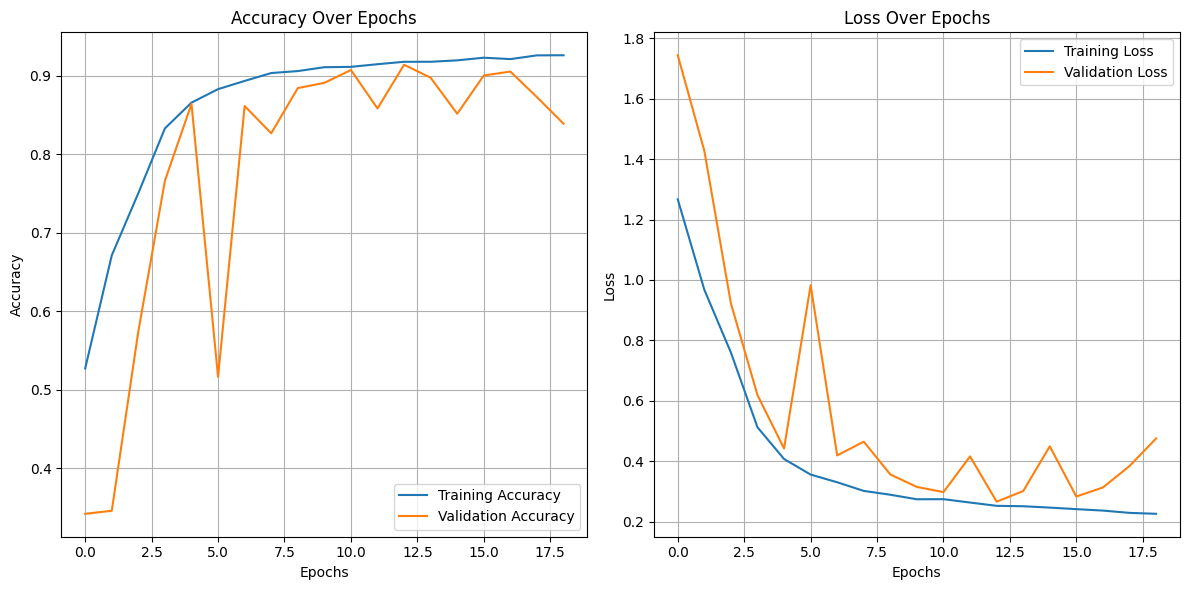

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# CBAM

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Permute,Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Multiply, Reshape, Add, Lambda, Concatenate, Activation,GlobalMaxPooling2D

from tensorflow.keras import backend as K

def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(128, 128, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='valid')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = cbam_block(x, 8)
x = MaxPooling2D(pool_size=(2, 2))(x)


x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = cbam_block(x, 8)
x = MaxPooling2D(pool_size=(2, 2))(x)


x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = cbam_block(x, 8)
x = MaxPooling2D(pool_size=(2, 2))(x)


x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(16, activation='relu')(x)


output_layer = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 126, 126, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 124, 124, 64)   │         36,928 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 124, 124, 64)   │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ batch_normalization_3… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_3    │ (None, 64)             │              0 │ batch_normalization_3… │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1, 1, 8)        │            520 │ reshape_6[0][0],       │
│                           │                        │                │ reshape_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1, 1, 64)       │            576 │ dense_9[0][0],         │
│                           │                        │                │ dense_9[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 1, 1, 64)       │              0 │ dense_10[0][0],        │
│                           │                        │                │ dense_10[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 1, 1, 64)       │              0 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_6 (Multiply)     │ (None, 124, 124, 64)   │              0 │ batch_normalization_3… │
│                           │                        │                │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 124, 124, 1)    │              0 │ multiply_6[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 124, 124, 1)    │              0 │ multiply_6[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3        

 Total params: 577,202 (2.20 MB)

 Trainable params: 576,818 (2.20 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=6,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Retinal OCT/SEnet/cbam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,

)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.75,
    patience=2,
    min_lr=0.00001
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr,checkpoint, early_stopping]
)

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6141 - loss: 1.0238
Epoch 1: val_accuracy improved from -inf to 0.63782, saving model to /content/drive/MyDrive/Retinal OCT/SEnet/cbam.weights.h5
620/620 ━━━━━━━━━━━━━━━━━━━━ 211s 291ms/step - accuracy: 0.6143 - loss: 1.0235 - val_accuracy: 0.6378 - val_loss: 0.8816 - learning_rate: 0.0010
Epoch 2/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8543 - loss: 0.4306
Epoch 2: val_accuracy did not improve from 0.63782
620/620 ━━━━━━━━━━━━━━━━━━━━ 213s 251ms/step - accuracy: 0.8543 - loss: 0.4305 - val_accuracy: 0.6007 - val_loss: 1.3479 - learning_rate: 0.0010
Epoch 3/35
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8984 - loss: 0.3007
Epoch 3: val_accuracy improved from 0.63782 to 0.63902, saving model to /content/drive/MyDrive/Retinal OCT/SEnet/cbam.weights.h5
620/620 ━━━━━━━━━━━━━━━━━━━━ 203s 252ms/step - accuracy: 0.8984 - loss: 0.3007 - val_accuracy: 0.6390 - val_loss: 1.0007 - learning_rate: 0.0010
Epoch 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 798ms/step - accuracy: 0.9824 - loss: 0.0719
Test Loss: 0.06626049429178238, Test Accuracy: 0.9834710955619812


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_predictions = model.predict(test_generator, verbose=1)

predicted_labels = np.argmax(test_predictions, axis=1)


true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step


In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

         CNV       0.96      1.00      0.98       242
         DME       1.00      0.95      0.97       242
      DRUSEN       1.00      1.00      1.00       242
      NORMAL       0.99      1.00      0.99       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



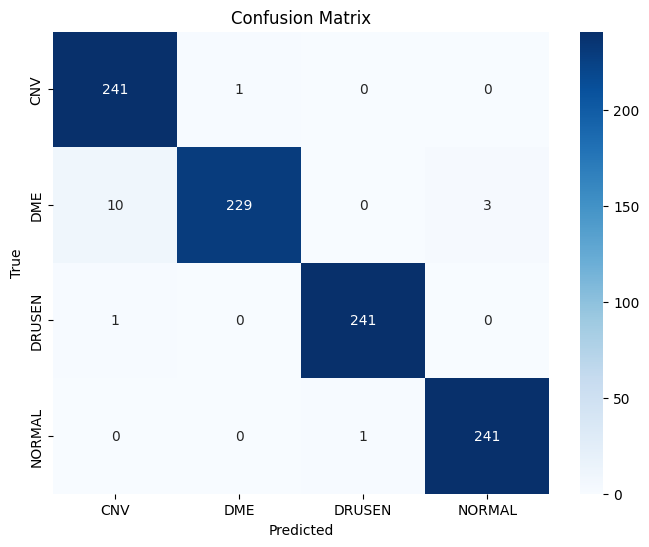

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

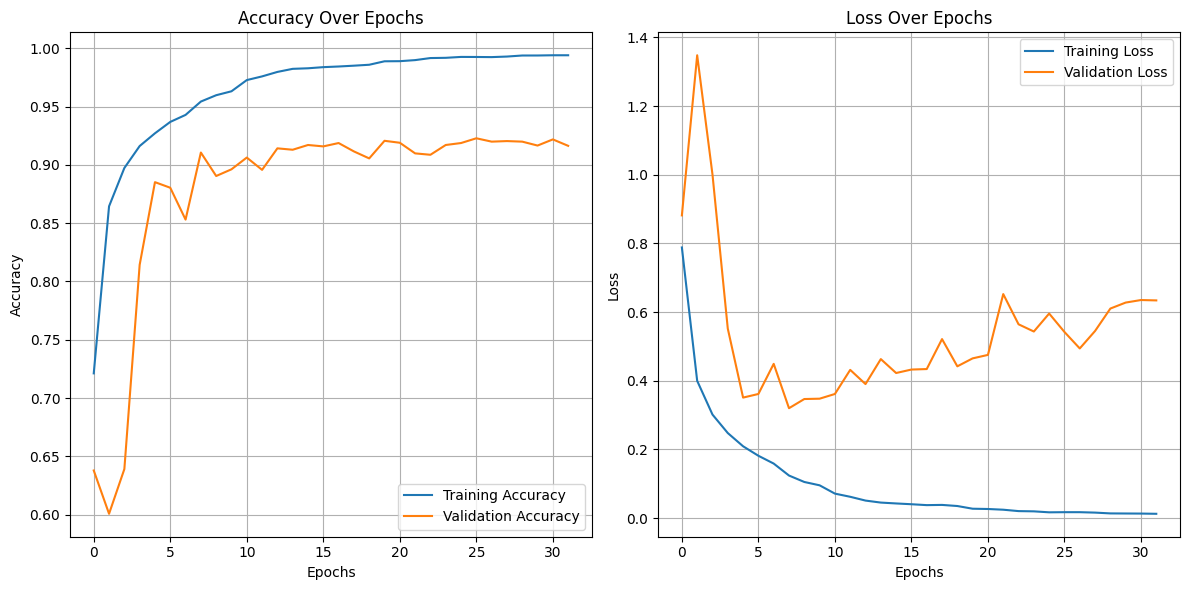

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Channel Attention

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(128, 128, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='valid')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = channel_attention(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = channel_attention(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = channel_attention(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(16, activation='relu')(x)


output_layer = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 124, 124, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 124, 124, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ batch_normalization[0… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 64)             │              0 │ batch_normalization[0… │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 64)       │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 8)        │            520 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 64)       │            576 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 64)       │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 64)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 124, 124, 64)   │              0 │ batch_normalization[0… │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 62, 62, 64)     │              0 │ multiply[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 62, 62, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1

 Total params: 576,908 (2.20 MB)

 Trainable params: 576,524 (2.20 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr,checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.5139 - loss: 1.1496 
Epoch 1: val_accuracy improved from -inf to 0.26846, saving model to /content/drive/MyDrive/Retinal OCT/SEnet/cbam.weights.h5
620/620 ━━━━━━━━━━━━━━━━━━━━ 15702s 25s/step - accuracy: 0.5142 - loss: 1.1492 - val_accuracy: 0.2685 - val_loss: 2.3593 - learning_rate: 0.0010


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on the test set
test_predictions = model.predict(test_generator, verbose=1)

predicted_labels = np.argmax(test_predictions, axis=1)


true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Spatial Attention

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(128, 128, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='valid')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = spatial_attention(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = spatial_attention(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = spatial_attention(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(16, activation='relu')(x)


output_layer = Dense(4, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=6,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Retinal OCT/SEnet/cbam.weights.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,

)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.75,
    patience=2,
    min_lr=0.00001
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr,checkpoint, early_stopping]
)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
test_predictions = model.predict(test_generator, verbose=1)

predicted_labels = np.argmax(test_predictions, axis=1)


true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Ensemble Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold
import os

In [ ]:
image_size = (128, 128)
batch_size = 64
input_shape = (128, 128, 1)
num_classes = 4
k_folds = 5

In [ ]:
path = ("D:/resized_oct/resized_oct")
os.listdir(path)

['test', 'train', 'val']

In [ ]:
train_dir = path + '/train'
os.listdir(train_dir)

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
test_dir = path + '/test'
os.listdir(test_dir)

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
myList = os.listdir(train_dir)
myList

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
import cv2
import os
import numpy as np

x_train = []
y_train = []
CATEGORIES = ['NORMAL', "CNV", "DME", "DRUSEN"]
for x in CATEGORIES:
    myPicList = os.listdir(os.path.join(train_dir, str(x)))
    for y in myPicList:
        if y != 'Thumbs.db':
            # Load image
            curImg = cv2.imread(os.path.join(train_dir, str(x), y), cv2.IMREAD_GRAYSCALE)
            curImg = cv2.resize(curImg, (128, 128))
            curImg = curImg / 255.0
            x_train.append(curImg)
            y_train.append(CATEGORIES.index(x))

    print(f"Processed {x} folder")


x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.expand_dims(x_train, axis=-1)

print(f"Training data shape: {x_train.shape}")
print(f"Labels shape: {y_train.shape}")


Processed NORMAL folder
Processed CNV folder
Processed DME folder
Processed DRUSEN folder
Training data shape: (83484, 128, 128, 1)
Labels shape: (83484,)


In [ ]:
import cv2
import os
import numpy as np

x_test = []
y_test = []
CATEGORIES = ['NORMAL', "CNV", "DME", "DRUSEN"]
for x in CATEGORIES:
    myPicList = os.listdir(os.path.join(test_dir, str(x)))
    for y in myPicList:
        if y != 'Thumbs.db':
            # Load image
            curImg = cv2.imread(os.path.join(test_dir, str(x), y), cv2.IMREAD_GRAYSCALE)
            curImg = cv2.resize(curImg, (128, 128))
            curImg = curImg / 255.0
            x_test.append(curImg)
            y_test.append(CATEGORIES.index(x))

    print(f"Processed {x} folder")

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.expand_dims(x_test, axis=-1)

print(f"Test data shape: {x_test.shape}")
print(f"Labels shape: {y_test.shape}")


Processed NORMAL folder
Processed CNV folder
Processed DME folder
Processed DRUSEN folder
Test data shape: (968, 128, 128, 1)
Labels shape: (968,)


In [ ]:
import cv2
import os
import numpy as np

x_test = []
y_test = []
CATEGORIES = ['NORMAL', "CNV", "DME", "DRUSEN"]
for x in CATEGORIES:
    myPicList = os.listdir(os.path.join(val_dir, str(x)))
    for y in myPicList:
        if y != 'Thumbs.db':
            # Load image
            curImg = cv2.imread(os.path.join(val_dir, str(x), y), cv2.IMREAD_GRAYSCALE)
            if curImg is None:
                print(f"Warning: could not read image {y} in class {x}, skipping...")
                continue  # Skip this image
            curImg = cv2.resize(curImg, (128, 128))
            curImg = curImg / 255.0
            x_test.append(curImg)
            y_test.append(CATEGORIES.index(x))

    print(f"Processed {x} folder")

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.expand_dims(x_test, axis=-1)

print(f"Test data shape: {x_test.shape}")
print(f"Labels shape: {y_test.shape}")


Processed NORMAL folder
Processed CNV folder
Processed DME folder
Processed DRUSEN folder
Test data shape: (32, 128, 128, 1)
Labels shape: (32,)


In [ ]:
import numpy as np
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Permute,Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Multiply, Reshape, Add, Lambda, Concatenate, Activation,GlobalMaxPooling2D

from tensorflow.keras import backend as K


# Define CBAM block
def cbam_block(cbam_feature, ratio=8):

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):

    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    cbam_feature = Conv2D(filters=1, kernel_size=kernel_size, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

In [ ]:
def create_model(input_shape=(128, 128, 1), num_classes=4):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), activation='relu', padding='valid')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = cbam_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)


    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = cbam_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = cbam_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)


    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# --- Define Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.75,
    patience=3,
    min_lr=0.00001
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=6,
    restore_best_weights=True
)

datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# --- KFold CV with Callbacks
k_folds = 5
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_no = 1
for train_index, val_index in stratified_kfold.split(x_train, y_train):
    print(f"\n--- Fold {fold_no} ---\n")

    X_tr, X_val = x_train[train_index], x_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_tr),
        y=y_tr
    )
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    model = create_model()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
        filepath=f'cbam_fold{fold_no}.h5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    )

    # Train the model with callbacks
    history = model.fit(
        datagen.flow(X_tr, y_tr, batch_size=32),
        validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
        epochs=40,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks=[reduce_lr, early_stopping, checkpoint]
    )

    # Evaluate on the fixed test set after each fold
    test_preds_proba = model.predict(x_test)
    test_preds = np.argmax(test_preds_proba, axis=1)

    print(f"Classification Report for Fold {fold_no} on Test Set:")
    print(classification_report(y_test, test_preds, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN']))
    print("done")

    fold_no += 1






--- Fold 1 ---

Epoch 1/40
2088/2088 [==============================] - ETA: 0s - loss: 0.7808 - accuracy: 0.7176     
Epoch 1: val_accuracy improved from -inf to 0.66036, saving model to cbam_fold1.h5
2088/2088 [==============================] - 236s 112ms/step - loss: 0.7808 - accuracy: 0.7176 - val_loss: 1.1012 - val_accuracy: 0.6604 - lr: 0.0010
Epoch 2/40
2088/2088 [==============================] - ETA: 0s - loss: 0.4302 - accuracy: 0.8605   
Epoch 2: val_accuracy improved from 0.66036 to 0.87375, saving model to cbam_fold1.h5
2088/2088 [==============================] - 237s 113ms/step - loss: 0.4302 - accuracy: 0.8605 - val_loss: 0.3731 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 3/40
2088/2088 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8935  
Epoch 3: val_accuracy improved from 0.87375 to 0.87692, saving model to cbam_fold1.h5
2088/2088 [==============================] - 235s 112ms/step - loss: 0.3266 - accuracy: 0.8935 - val_loss: 0.3652 - val_accu

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from tensorflow.keras.models import load_model

# --- Ensemble all models after cross-validation
print("\n--- Ensemble Evaluation on Test Set ---\n")

ensemble_probs = []

for i in range(1, k_folds + 1):

    model = create_model()
    model.load_weights(f'C:/Users/maria/OCT/cbam_fold{i}.h5')
    preds_proba = model.predict(x_test)
    ensemble_probs.append(preds_proba)

ensemble_probs = np.array(ensemble_probs)
avg_probs = np.mean(ensemble_probs, axis=0)
final_preds = np.argmax(avg_probs, axis=1)

# Final ensemble report
print("Ensemble Classification Report on Test Set (Probability Averaging):")
print(classification_report(y_test, final_preds, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))

# Ensemble accuracy
ensemble_acc = accuracy_score(y_test, final_preds)
print(f"Ensemble Accuracy on Test Set: {ensemble_acc:.4f}")



--- Ensemble Evaluation on Test Set ---

31/31 [==============================] - 1s 28ms/step
Ensemble Classification Report on Test Set (Probability Averaging):
              precision    recall  f1-score   support

      NORMAL     0.9959    1.0000    0.9979       242
         CNV     0.9878    1.0000    0.9938       242
         DME     1.0000    0.9835    0.9917       242
      DRUSEN     1.0000    1.0000    1.0000       242

    accuracy                         0.9959       968
   macro avg     0.9959    0.9959    0.9959       968
weighted avg     0.9959    0.9959    0.9959       968

Ensemble Accuracy on Test Set: 0.9959


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score #our data test portion
import numpy as np
from tensorflow.keras.models import load_model

# --- Ensemble all models after cross-validation
print("\n--- Ensemble Evaluation on Test Set ---\n")

ensemble_probs = []

for i in range(1, k_folds + 1):
    print(f"\n--- Fold {i} Evaluation ---")
    model = create_model()
    model.load_weights(f'C:/Users/maria/OCT/cbam_fold{i}.h5')
    preds_proba = model.predict(x_test)
    preds_fold = np.argmax(preds_proba, axis=1)

    # --- Fold-wise metrics ---
    print(f"\nClassification Report for Fold {i}:")
    print(classification_report(y_test, preds_fold, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))

    print(f"\nConfusion Matrix for Fold {i}:")
    print(confusion_matrix(y_test, preds_fold))

    # Collect probabilities for ensemble
    ensemble_probs.append(preds_proba)

# After all folds: Ensemble prediction
ensemble_probs = np.array(ensemble_probs)
avg_probs = np.mean(ensemble_probs, axis=0)
final_preds = np.argmax(avg_probs, axis=1)

# --- Ensemble metrics ---
print("\n--- Final Ensemble Results ---")
print("Ensemble Classification Report on Test Set (Probability Averaging):")
print(classification_report(y_test, final_preds, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))

ensemble_acc = accuracy_score(y_test, final_preds)
print(f"Ensemble Accuracy on Test Set: {ensemble_acc:.4f}")



--- Ensemble Evaluation on Test Set ---


--- Fold 1 Evaluation ---
31/31 [==============================] - 2s 39ms/step

Classification Report for Fold 1:
              precision    recall  f1-score   support

      NORMAL     1.0000    0.9917    0.9959       242
         CNV     0.9272    1.0000    0.9622       242
         DME     1.0000    0.9628    0.9811       242
      DRUSEN     0.9872    0.9545    0.9706       242

    accuracy                         0.9773       968
   macro avg     0.9786    0.9773    0.9774       968
weighted avg     0.9786    0.9773    0.9774       968


Confusion Matrix for Fold 1:
[[240   0   0   2]
 [  0 242   0   0]
 [  0   8 233   1]
 [  0  11   0 231]]

--- Fold 2 Evaluation ---
31/31 [==============================] - 2s 29ms/step

Classification Report for Fold 2:
              precision    recall  f1-score   support

      NORMAL     1.0000    1.0000    1.0000       242
         CNV     0.9837    1.0000    0.9918       242
         DME     1.00

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # this is our own data val portion
import numpy as np
from tensorflow.keras.models import load_model

# --- Ensemble all models after cross-validation
print("\n--- Ensemble Evaluation on Test Set ---\n")

ensemble_probs = []

for i in range(1, k_folds + 1):
    print(f"\n--- Fold {i} Evaluation ---")
    model = create_model()
    model.load_weights(f'C:/Users/maria/OCT/cbam_fold{i}.h5')
    preds_proba = model.predict(x_test)
    preds_fold = np.argmax(preds_proba, axis=1)

    # --- Fold-wise metrics ---
    print(f"\nClassification Report for Fold {i}:")
    print(classification_report(y_test, preds_fold, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))

    print(f"\nConfusion Matrix for Fold {i}:")
    print(confusion_matrix(y_test, preds_fold))

    ensemble_probs.append(preds_proba)


ensemble_probs = np.array(ensemble_probs)
avg_probs = np.mean(ensemble_probs, axis=0)
final_preds = np.argmax(avg_probs, axis=1)

# --- Ensemble metrics ---
print("\n--- Final Ensemble Results ---")
print("Ensemble Classification Report on Test Set (Probability Averaging):")
print(classification_report(y_test, final_preds, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))

ensemble_acc = accuracy_score(y_test, final_preds)
print(f"Ensemble Accuracy on Test Set: {ensemble_acc:.4f}")



--- Ensemble Evaluation on Test Set ---


--- Fold 1 Evaluation ---
1/1 [==============================] - 5s 5s/step

Classification Report for Fold 1:
              precision    recall  f1-score   support

      NORMAL     1.0000    1.0000    1.0000         8
         CNV     0.8000    1.0000    0.8889         8
         DME     1.0000    0.8750    0.9333         8
      DRUSEN     1.0000    0.8750    0.9333         8

    accuracy                         0.9375        32
   macro avg     0.9500    0.9375    0.9389        32
weighted avg     0.9500    0.9375    0.9389        32


Confusion Matrix for Fold 1:
[[8 0 0 0]
 [0 8 0 0]
 [0 1 7 0]
 [0 1 0 7]]

--- Fold 2 Evaluation ---
1/1 [==============================] - 0s 170ms/step

Classification Report for Fold 2:
              precision    recall  f1-score   support

      NORMAL     1.0000    1.0000    1.0000         8
         CNV     0.8889    1.0000    0.9412         8
         DME     1.0000    0.8750    0.9333         8
    

# Confusion Matrix


Confusion Matrix:
[[242   0   0   0]
 [  0 242   0   0]
 [  1   3 238   0]
 [  0   0   0 242]]


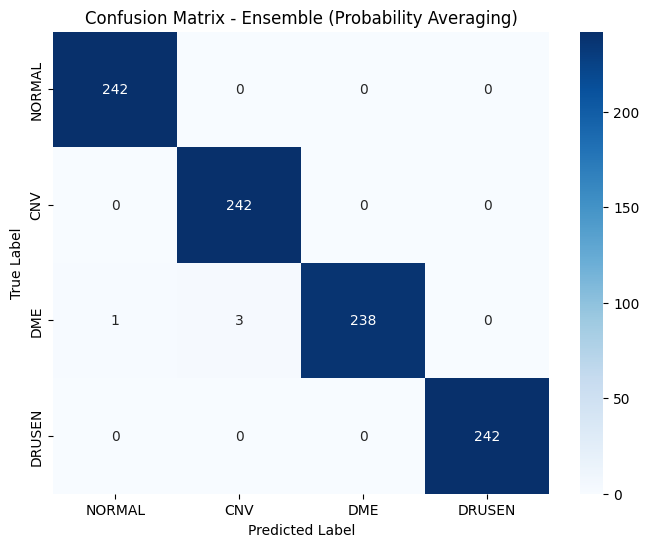

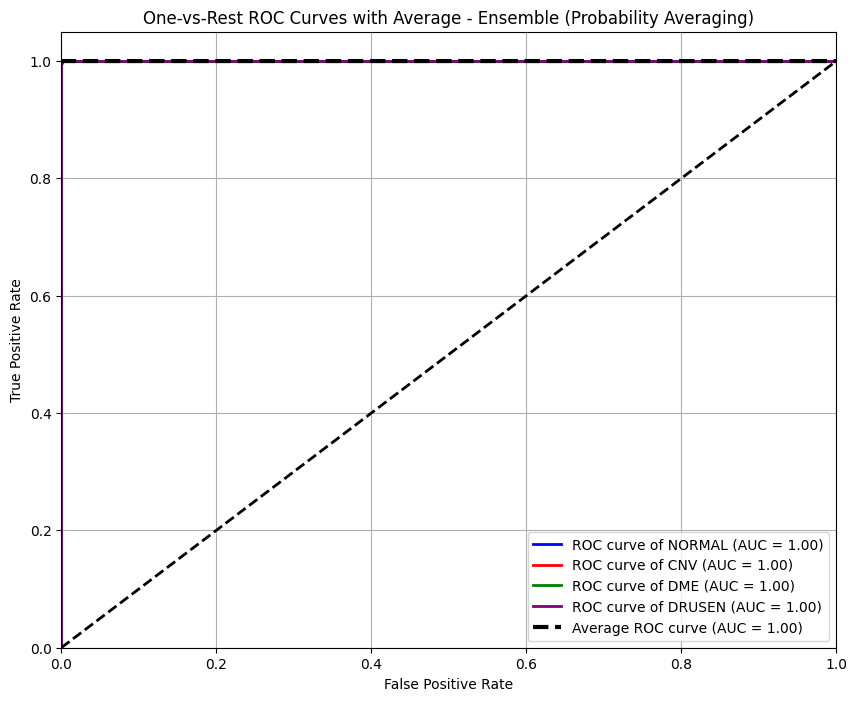

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import seaborn as sns

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_preds)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['NORMAL', 'CNV', 'DME', 'DRUSEN'],
            yticklabels=['NORMAL', 'CNV', 'DME', 'DRUSEN'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Ensemble (Probability Averaging)')
plt.show()


class_names = ['NORMAL', 'CNV', 'DME', 'DRUSEN']

n_classes = len(class_names)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], avg_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

avg_fpr = all_fpr
avg_tpr = mean_tpr
avg_roc_auc = auc(avg_fpr, avg_tpr)

# --- Plot ROC curves ---
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(avg_fpr, avg_tpr, color='black', linestyle='--', linewidth=3,
         label=f'Average ROC curve (AUC = {avg_roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves with Average - Ensemble (Probability Averaging)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# ROC

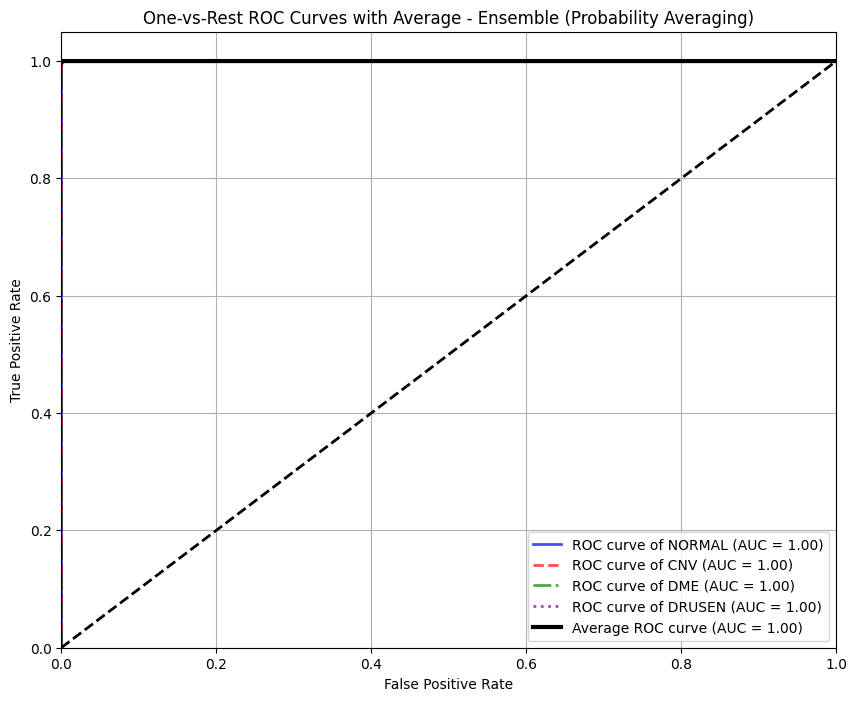

In [ ]:
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'purple']
linestyles = ['-', '--', '-.', ':']

# Plot per-class ROC curves (with alpha and different line styles)
for i, (color, style) in enumerate(zip(colors, linestyles)):
    plt.plot(fpr[i], tpr[i],
             color=color,
             linestyle=style,
             lw=2,
             alpha=0.7,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the average ROC curve last so it’s on top
plt.plot(avg_fpr, avg_tpr,
         color='black',
         linestyle='-',
         linewidth=3,
         label=f'Average ROC curve (AUC = {avg_roc_auc:.2f})')

# Plot diagonal (chance line)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves with Average - Ensemble (Probability Averaging)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Zoomed ROC

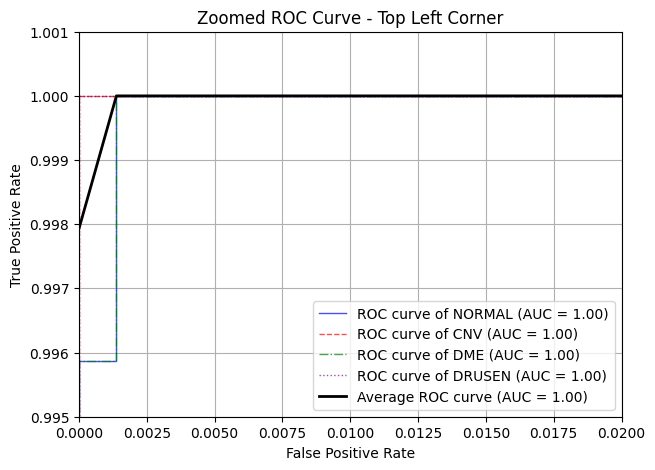

In [ ]:
plt.figure(figsize=(7, 5))

colors = ['blue', 'red', 'green', 'purple']
linestyles = ['-', '--', '-.', ':']

# Plot per-class ROC curves
for i, (color, style) in enumerate(zip(colors, linestyles)):
    plt.plot(fpr[i], tpr[i],
             color=color,
             linestyle=style,
             lw=1,
             alpha=0.7,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Average ROC curve on top
plt.plot(avg_fpr, avg_tpr,
         color='black',
         linestyle='-',
         linewidth=2,
         label=f'Average ROC curve (AUC = {avg_roc_auc:.2f})')

# Diagonal reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Zoom into top-left corner
plt.xlim([0.0, 0.02])
plt.ylim([0.995, 1.001])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed ROC Curve - Top Left Corner')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Generalization

# Generralization dataset : https://www.kaggle.com/datasets/obulisainaren/retinal-oct-c8


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold
import os

In [ ]:
image_size = (128, 128)
batch_size = 64
input_shape = (128, 128, 1)
num_classes = 4
k_folds = 5

In [ ]:
path = r'D:\resized_oct\New_retina_oct\RetinalOCT_Dataset\RetinalOCT_Dataset'
os.listdir(path)

['test', 'train', 'val']

In [ ]:
train_dir = path + '/train'
os.listdir(train_dir)

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
test_dir = path + '/test'
os.listdir(test_dir)

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
val_dir = path + '/val'
os.listdir(test_dir)

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
myList = os.listdir(train_dir)
myList

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [ ]:
import cv2
import os
import numpy as np

x_test = []
y_test = []
CATEGORIES = ['NORMAL', "CNV", "DME", "DRUSEN"]
for x in CATEGORIES:
    myPicList = os.listdir(os.path.join(train_dir, str(x)))
    for y in myPicList:
        if y != 'Thumbs.db':
            # Load image
            curImg = cv2.imread(os.path.join(train_dir, str(x), y), cv2.IMREAD_GRAYSCALE)
            curImg = cv2.resize(curImg, (128, 128))
            curImg = curImg / 255.0
            x_test.append(curImg)
            y_test.append(CATEGORIES.index(x))

    print(f"Processed {x} folder")


x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.expand_dims(x_test, axis=-1)

print(f"Training data shape: {x_test.shape}")
print(f"Labels shape: {y_test.shape}")


Processed NORMAL folder
Processed CNV folder
Processed DME folder
Processed DRUSEN folder
Training data shape: (9200, 128, 128, 1)
Labels shape: (9200,)


In [ ]:
import cv2
import os
import numpy as np

x_test = []
y_test = []
CATEGORIES = ['NORMAL', "CNV", "DME", "DRUSEN"]
for x in CATEGORIES:
    myPicList = os.listdir(os.path.join(test_dir, str(x)))
    for y in myPicList:
        if y != 'Thumbs.db':
            # Load image
            curImg = cv2.imread(os.path.join(test_dir, str(x), y), cv2.IMREAD_GRAYSCALE)
            curImg = cv2.resize(curImg, (128, 128))
            curImg = curImg / 255.0
            x_test.append(curImg)
            y_test.append(CATEGORIES.index(x))

    print(f"Processed {x} folder")

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.expand_dims(x_test, axis=-1)

print(f"Test data shape: {x_test.shape}")
print(f"Labels shape: {y_test.shape}")


Processed NORMAL folder
Processed CNV folder
Processed DME folder
Processed DRUSEN folder
Test data shape: (1400, 128, 128, 1)
Labels shape: (1400,)


In [ ]:
import cv2
import os
import numpy as np

x_test = []
y_test = []
CATEGORIES = ['NORMAL', "CNV", "DME", "DRUSEN"]
for x in CATEGORIES:
    myPicList = os.listdir(os.path.join(val_dir, str(x)))
    for y in myPicList:
        if y != 'Thumbs.db':
            # Load image
            curImg = cv2.imread(os.path.join(val_dir, str(x), y), cv2.IMREAD_GRAYSCALE)
            if curImg is None:
                print(f"Warning: could not read image {y} in class {x}, skipping...")
                continue  # Skip this image
            curImg = cv2.resize(curImg, (128, 128))
            curImg = curImg / 255.0
            x_test.append(curImg)
            y_test.append(CATEGORIES.index(x))

    print(f"Processed {x} folder")

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = np.expand_dims(x_test, axis=-1)

print(f"Test data shape: {x_test.shape}")
print(f"Labels shape: {y_test.shape}")


Processed NORMAL folder
Processed CNV folder
Processed DME folder
Processed DRUSEN folder
Test data shape: (1400, 128, 128, 1)
Labels shape: (1400,)


In [ ]:
import numpy as np
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # this is train  results
import numpy as np
from tensorflow.keras.models import load_model

# --- Ensemble all models after cross-validation
print("\n--- Ensemble Evaluation on Test Set ---\n")

ensemble_probs = []

for i in range(1, k_folds + 1):
    print(f"\n--- Fold {i} Evaluation ---")
    model = create_model()
    model.load_weights(f'C:/Users/maria/OCT/cbam_fold{i}.h5')
    preds_proba = model.predict(x_train)
    preds_fold = np.argmax(preds_proba, axis=1)

    # --- Fold-wise metrics ---
    print(f"\nClassification Report for Fold {i}:")
    print(classification_report(y_test, preds_fold, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))

    print(f"\nConfusion Matrix for Fold {i}:")
    print(confusion_matrix(y_test, preds_fold))

    # Collect probabilities for ensemble
    ensemble_probs.append(preds_proba)

# After all folds: Ensemble prediction
ensemble_probs = np.array(ensemble_probs)
avg_probs = np.mean(ensemble_probs, axis=0)
final_preds = np.argmax(avg_probs, axis=1)

# --- Ensemble metrics ---
print("\n--- Final Ensemble Results ---")
print("Ensemble Classification Report on Test Set (Probability Averaging):")
print(classification_report(y_test, final_preds, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))

ensemble_acc = accuracy_score(y_test, final_preds)
print(f"Ensemble Accuracy on Test Set: {ensemble_acc:.4f}")



--- Ensemble Evaluation on Test Set ---


--- Fold 1 Evaluation ---
288/288 [==============================] - 9s 30ms/step

Classification Report for Fold 1:
              precision    recall  f1-score   support

      NORMAL     0.9390    0.9843    0.9612      2300
         CNV     0.9159    0.9709    0.9426      2300
         DME     0.9927    0.9457    0.9686      2300
      DRUSEN     0.9671    0.9083    0.9368      2300

    accuracy                         0.9523      9200
   macro avg     0.9537    0.9523    0.9523      9200
weighted avg     0.9537    0.9523    0.9523      9200


Confusion Matrix for Fold 1:
[[2264    9    7   20]
 [  12 2233    7   48]
 [  73   49 2175    3]
 [  62  147    2 2089]]

--- Fold 2 Evaluation ---
288/288 [==============================] - 9s 30ms/step

Classification Report for Fold 2:
              precision    recall  f1-score   support

      NORMAL     0.9777    0.9922    0.9849      2300
         CNV     0.9697    0.9865    0.9780      2300
 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # this is val results
import numpy as np
from tensorflow.keras.models import load_model

# --- Ensemble all models after cross-validation
print("\n--- Ensemble Evaluation on Test Set ---\n")

ensemble_probs = []

for i in range(1, k_folds + 1):
    print(f"\n--- Fold {i} Evaluation ---")
    model = create_model()
    model.load_weights(f'C:/Users/maria/OCT/cbam_fold{i}.h5')
    preds_proba = model.predict(x_val)
    preds_fold = np.argmax(preds_proba, axis=1)
    print(f"\nClassification Report for Fold {i}:")
    print(classification_report(y_test, preds_fold, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))
    print(f"\nConfusion Matrix for Fold {i}:")
    print(confusion_matrix(y_test, preds_fold))

    # Collect probabilities for ensemble
    ensemble_probs.append(preds_proba)

# After all folds: Ensemble prediction
ensemble_probs = np.array(ensemble_probs)
avg_probs = np.mean(ensemble_probs, axis=0)
final_preds = np.argmax(avg_probs, axis=1)

# --- Ensemble metrics ---
print("\n--- Final Ensemble Results ---")
print("Ensemble Classification Report on Test Set (Probability Averaging):")
print(classification_report(y_test, final_preds, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))

ensemble_acc = accuracy_score(y_test, final_preds)
print(f"Ensemble Accuracy on Test Set: {ensemble_acc:.4f}")



--- Ensemble Evaluation on Test Set ---


--- Fold 1 Evaluation ---
44/44 [==============================] - 2s 28ms/step

Classification Report for Fold 1:
              precision    recall  f1-score   support

      NORMAL     0.9247    0.9829    0.9529       350
         CNV     0.9440    0.9629    0.9533       350
         DME     0.9819    0.9286    0.9545       350
      DRUSEN     0.9706    0.9429    0.9565       350

    accuracy                         0.9543      1400
   macro avg     0.9553    0.9543    0.9543      1400
weighted avg     0.9553    0.9543    0.9543      1400


Confusion Matrix for Fold 1:
[[344   1   2   3]
 [  2 337   4   7]
 [ 20   5 325   0]
 [  6  14   0 330]]

--- Fold 2 Evaluation ---
44/44 [==============================] - 2s 29ms/step

Classification Report for Fold 2:
              precision    recall  f1-score   support

      NORMAL     0.9803    0.9971    0.9887       350
         CNV     0.9746    0.9886    0.9816       350
         DME     0.99

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # this is test results
import numpy as np
from tensorflow.keras.models import load_model

# --- Ensemble all models after cross-validation
print("\n--- Ensemble Evaluation on Test Set ---\n")

ensemble_probs = []

for i in range(1, k_folds + 1):
    print(f"\n--- Fold {i} Evaluation ---")

    model = create_model()
    model.load_weights(f'C:/Users/maria/OCT/cbam_fold{i}.h5')

    preds_proba = model.predict(x_test)
    preds_fold = np.argmax(preds_proba, axis=1)

    # --- Fold-wise metrics ---
    print(f"\nClassification Report for Fold {i}:")
    print(classification_report(y_test, preds_fold, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))

    print(f"\nConfusion Matrix for Fold {i}:")
    print(confusion_matrix(y_test, preds_fold))


    ensemble_probs.append(preds_proba)

# After all folds: Ensemble prediction
ensemble_probs = np.array(ensemble_probs)
avg_probs = np.mean(ensemble_probs, axis=0)
final_preds = np.argmax(avg_probs, axis=1)

# --- Ensemble metrics ---
print("\n--- Final Ensemble Results ---")
print("Ensemble Classification Report on Test Set (Probability Averaging):")
print(classification_report(y_test, final_preds, target_names=['NORMAL', 'CNV', 'DME', 'DRUSEN'], digits=4))

ensemble_acc = accuracy_score(y_test, final_preds)
print(f"Ensemble Accuracy on Test Set: {ensemble_acc:.4f}")



--- Ensemble Evaluation on Test Set ---


--- Fold 1 Evaluation ---
44/44 [==============================] - 4s 35ms/step

Classification Report for Fold 1:
              precision    recall  f1-score   support

      NORMAL     0.9270    0.9800    0.9528       350
         CNV     0.9053    0.9829    0.9425       350
         DME     0.9846    0.9143    0.9481       350
      DRUSEN     0.9815    0.9114    0.9452       350

    accuracy                         0.9471      1400
   macro avg     0.9496    0.9471    0.9471      1400
weighted avg     0.9496    0.9471    0.9471      1400


Confusion Matrix for Fold 1:
[[343   1   4   2]
 [  2 344   1   3]
 [ 14  15 320   1]
 [ 11  20   0 319]]

--- Fold 2 Evaluation ---
44/44 [==============================] - 2s 29ms/step

Classification Report for Fold 2:
              precision    recall  f1-score   support

      NORMAL     0.9692    0.9886    0.9788       350
         CNV     0.9774    0.9886    0.9830       350
         DME     0.98